In [1]:
# `cnn_4_llm_memo`

# Copyright 2025-present Laboratoire d'Informatique de Polytechnique.
# Apache Licence v2.0.

import os

os.chdir(os.path.dirname(os.path.abspath('')))

**WARNING: This notebook must be executed on the same machine as the one where the attention patterns are stored. Or, alternatively, you can extract some specific patterns and store a smaller *.h5py* file locally using `06_extract_patterns.ipynb` notebook remotely.**

## Setup

In [2]:
import src

In [3]:
from src.detect import (
    DetectConfig,
    Cnn2D,
    GuidedBackPropagation,
)
from src.detect.guided_grad_cam import *
from src.patterns import (
    PatternsConfig,
    get_train_eval_test,
    get_patterns_for_repr,
    plot_multisentence_multilayer,
)
from src.utils.constants import *
from src.utils import paths

In [4]:
from collections import defaultdict
import gc

from tqdm import tqdm
import torch
import numpy as np
from loguru import logger
from matplotlib import pyplot as plt

In [ ]:
# You can use the following to declare your base output dir if it is not ./output

# import os
# os.environ["_BASE_OUTPUT_DIR"] = "/lustre/fsn1/projects/rech/yfw/upp42qa/output_regu_detect"

In [5]:
SAVE_FIG = True
NUM_SAMPLE = 200
EPOCH = 2
PATTERNS_CFG = "rasy"

In [23]:
TITLES = ["Non-Memo", "Guess", "Recall"]

## Configs

In [6]:
patterns_cfg = PatternsConfig.autoconfig(PATTERNS_CFG, reset_output_dir=True)
patterns_cfg

PatternsConfig[ rasyq52cr19yVj72U1ZkFQ ](
	_base_output_dir: .
	deduped: True
	duplicates_threshold: 50
	eval_base_size: 2000
	inference_bs: 16
	rouge_threshold: 0.5
	seed: 42
	size: 12b
	tax_name: merge_2_other_guess_recollect_recite
	train_base_size: 4000
)

In [7]:
detect_cfg_list = []
for child in (paths.output / "detect").iterdir():
    detect_cfg = DetectConfig.from_json(child / "config.json", reset_output_dir=True)
    if detect_cfg.patterns_config != patterns_cfg.get_id():
        continue

    detect_cfg_list.append(detect_cfg)

len(detect_cfg_list)

8

In [8]:
df = get_train_eval_test(patterns_cfg)
df

2025-05-15 09:39:45.479 | INFO     | src.patterns.datasets:get_train_eval_test:359 - Looking in cache: /Users/jeremie/Documents/01-Travail/01-Doctorat/regu-detect/output/patterns/rasyq52cr19yVj72U1ZkFQ/train_eval_test.parquet
2025-05-15 09:39:45.491 | INFO     | src.patterns.datasets:get_train_eval_test:364 - Reading dataset from /Users/jeremie/Documents/01-Travail/01-Doctorat/regu-detect/output/patterns/rasyq52cr19yVj72U1ZkFQ/train_eval_test.parquet


,sequence_id,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,...,huffman_coding_length,memorization_score,rouge_3_prefix_to_suffix,rouge_L_prefix_to_suffix,is_code,cat_0,cat_1,cat_2,part_train,part_eval
0,123188638,2.695312,8.382993,4.787971,40.137524,"muscle car And all the wheels are mag"" ""You m...",False,False,3,9362638615,...,4.807087,0.00000,0.066667,0.18750,False,True,False,False,True,False
1,694127,2.589844,3.405081,4.933641,16.799450,"I}}}},{{{\bm{Q}}}})$ for some ${{\tilde{\rho}}...",False,False,1,8485755698,...,5.313901,0.00000,0.000000,0.03125,False,True,False,False,True,False
2,46600814,2.287109,3.178704,2.326551,7.395417,"infinity of ${\mathbb{H}^2}$. In other words,...",False,False,2,9362638615,...,5.187215,0.00000,0.100000,0.15625,False,True,False,False,True,False
3,142041746,2.753906,2.736737,2.046753,5.601426,"C_KDBXREADER_H\n\n#include ""KeePass2.h""\n#incl...",False,False,4,11740996961,...,5.416667,0.21875,0.233333,0.31250,True,True,False,False,True,False
4,35242275,2.638672,3.602310,3.970338,14.302387,not as means to the ends of others; to recogn...,False,False,2,9362638615,...,4.604651,0.00000,0.000000,0.18750,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,16515813,0.559570,1.156433,1.009487,1.167404,License. You may obtain a copy of the Licens...,False,False,14853,11740996961,...,5.136752,1.00000,0.066667,0.12500,True,False,False,True,False,True
17996,19641834,0.711426,3.406995,1.033262,3.520319,reference to Newtonsoft.Json.dll within Visua...,False,False,2,11740996961,...,5.321799,1.00000,0.000000,0.09375,True,False,False,True,False,True
17997,8495410,0.575195,1.910261,1.011234,1.931721,"Internet,” Trump said.Kaplan-Meier plots summ...",False,False,125,10346382453,...,4.944954,1.00000,0.066667,0.15625,False,False,False,True,False,True
17998,95556049,0.619141,2.869972,1.005987,2.887155,"in Paris, and many others. She teaches creati...",False,False,561,11740996961,...,5.011364,1.00000,0.000000,0.06250,False,False,False,True,False,True


In [9]:
num_classes = len([col for col in df.columns if "cat_" in col])
logger.debug(f"Automatic dection of num classes: {num_classes}")
for idx_class in range(num_classes):
    logger.debug(f"Num class {idx_class}: {sum(df[f'cat_{idx_class}'])}")

2025-05-15 09:39:45.759 | DEBUG    | __main__:<module>:2 - Automatic dection of num classes: 3
2025-05-15 09:39:45.787 | DEBUG    | __main__:<module>:4 - Num class 0: 6000
2025-05-15 09:39:45.797 | DEBUG    | __main__:<module>:4 - Num class 1: 6000
2025-05-15 09:39:45.799 | DEBUG    | __main__:<module>:4 - Num class 2: 6000


## Loading CNNs

In [10]:
cnns = []

for detect_cfg in detect_cfg_list:
    model = Cnn2D(
        kernel_size=detect_cfg.kernel_size,
        pooling_kernel=detect_cfg.pooling_kernel,
        n_feat_cnn=detect_cfg.n_feat_cnn,
        n_feat_fc=detect_cfg.n_feat_fc,
        n_class=num_classes,
        model_size=patterns_cfg.size,
    )

    model.load_state_dict(
        torch.load(
            detect_cfg.get_output_dir() / "cnn_2d" / f"model_{EPOCH}.pt", weights_only=True,
            map_location=DEVICE,
        )
    )
    model = model.to(DEVICE)
    cnns.append(model)

## Loading some attention patterns

In [11]:
list_of_ids_to_get = []

for idx_class in range(num_classes):
    for loc in np.where(df[f"cat_{idx_class}"])[0][:NUM_SAMPLE]:
        list_of_ids_to_get.append(df.loc[loc, "sequence_id"])

print(len(list_of_ids_to_get))

import pickle
with open(paths.figures / ".ipynb_cache" / "A-nL.pickle", "wb") as f:
    pickle.dump(list_of_ids_to_get, f)

600


In [12]:
attention_patterns_per_class = dict()

for idx_class in range(num_classes):

    attention_patterns_per_class[idx_class] = torch.stack([
        get_patterns_for_repr(df, patterns_cfg, loc)
        for loc in np.where(df[f"cat_{idx_class}"])[0][:NUM_SAMPLE]
    ]).to(DEVICE)

## Computing Delta

In [13]:
delta_matrix = torch.zeros(num_classes, 36, 1, 64, 64)

for cnn_idx in range(len(cnns)):
    logger.info(f"Processing cnn idx: {cnn_idx}")

    model = cnns[cnn_idx]

    # ===================================
    # B matrix and Guided BackPropagation
    # ===================================

    b_matrix = defaultdict(dict)

    for origin_label in range(num_classes):

        logger.info(f"Processing images of class {origin_label}")
        
        for dest_label in tqdm(range(num_classes)):

            b_matrix[origin_label][dest_label] = torch.zeros(NUM_SAMPLE, 36, 40, 64, 64)
            labels = torch.Tensor(
                    [dest_label for _ in range(NUM_SAMPLE)]
                ).long().to(DEVICE)

            for batch_idx in range(2):
                batch_size = NUM_SAMPLE//2
                
                model.zero_grad()
                gbp = GuidedBackPropagation(model=model)
                _ = gbp.forward(attention_patterns_per_class[origin_label][batch_idx*batch_size : (batch_idx+1)*batch_size].to(DEVICE))
                gbp.backward(labels[batch_idx*batch_size : (batch_idx+1)*batch_size])

                b_matrix[origin_label][dest_label][batch_idx*batch_size : (batch_idx+1)*batch_size] = gbp.generate().detach()

                # Cleaning
                del gbp
                gc.collect()
                torch.mps.empty_cache()
        
        logger.debug(f"gradients_{origin_label}: {len(b_matrix[origin_label])} elements of size {b_matrix[origin_label][0].size()}")

    # ===================================
    # C matrix
    # ===================================
    
    c_matrix = {}

    logger.info(f"Computing C matrix...")
    for origin_label in tqdm(range(num_classes)):

        grad_stab = b_matrix[origin_label][origin_label]
        for dest_label in range(num_classes):
            if dest_label != origin_label:
                grad_stab -= (b_matrix[origin_label][dest_label] / (num_classes - 1))

        c_matrix[origin_label] = grad_stab

    # Cleaning
    del b_matrix
    torch.mps.empty_cache()
    gc.collect()

    # Logging
    for idx, elt in c_matrix.items():
        logger.debug(f"Class {idx}: {elt.size()}")

    # ===================================
    # D matrix
    # ===================================
    
    def normalize_and_clip_gradient(gradients):
        B, L, C, H, W = gradients.size()
        grad_vals = gradients.view(B, -1)
        max_vals = torch.max(grad_vals, dim=1)[0][:, None]
        grad_vals = torch.clip(grad_vals / max_vals, min=0)

        return grad_vals.view(B, L, C, H, W)

    d_matrix = {key: normalize_and_clip_gradient(value) for key, value in c_matrix.items()}

    # Cleaning
    del c_matrix
    torch.mps.empty_cache()
    gc.collect()

    # ===================================
    # Delta matrix
    # ===================================

    delta_matrix += torch.stack([
        torch.mean(torch.amax(d_matrix[idx_class].cpu() * attention_patterns_per_class[idx_class].detach().cpu(), axis=2, keepdim=True), axis=0)
        for idx_class in range(num_classes)
    ])

    # Cleaning
    del d_matrix
    torch.mps.empty_cache()
    gc.collect()


2025-05-15 09:39:50.806 | INFO     | __main__:<module>:4 - Processing cnn idx: 0
2025-05-15 09:39:50.807 | INFO     | __main__:<module>:16 - Processing images of class 0
100%|██████████| 3/3 [00:05<00:00,  1.72s/it]
2025-05-15 09:39:55.983 | DEBUG    | __main__:<module>:40 - gradients_0: 3 elements of size torch.Size([200, 36, 40, 64, 64])
2025-05-15 09:39:55.983 | INFO     | __main__:<module>:16 - Processing images of class 1
100%|██████████| 3/3 [00:06<00:00,  2.13s/it]
2025-05-15 09:40:02.371 | DEBUG    | __main__:<module>:40 - gradients_1: 3 elements of size torch.Size([200, 36, 40, 64, 64])
2025-05-15 09:40:02.371 | INFO     | __main__:<module>:16 - Processing images of class 2
100%|██████████| 3/3 [00:14<00:00,  4.95s/it]
2025-05-15 09:40:17.235 | DEBUG    | __main__:<module>:40 - gradients_2: 3 elements of size torch.Size([200, 36, 40, 64, 64])
2025-05-15 09:40:17.238 | INFO     | __main__:<module>:48 - Computing C matrix...
100%|██████████| 3/3 [00:51<00:00, 17.11s/it]
2025-05-

In [14]:
# Averaging over CNNs
delta_matrix /= len(cnns)

In [24]:
to_plot = delta_matrix / torch.amax(delta_matrix, dim=(0,2,3,4))[None, :, None, None, None] # Normalize per layer for better readability
# The relative importance of each layer is discussed below

logger.debug(f"logger.debug: {to_plot.size()}")

2025-05-15 11:02:08.777 | DEBUG    | __main__:<module>:4 - logger.debug: torch.Size([3, 36, 1, 64, 64])


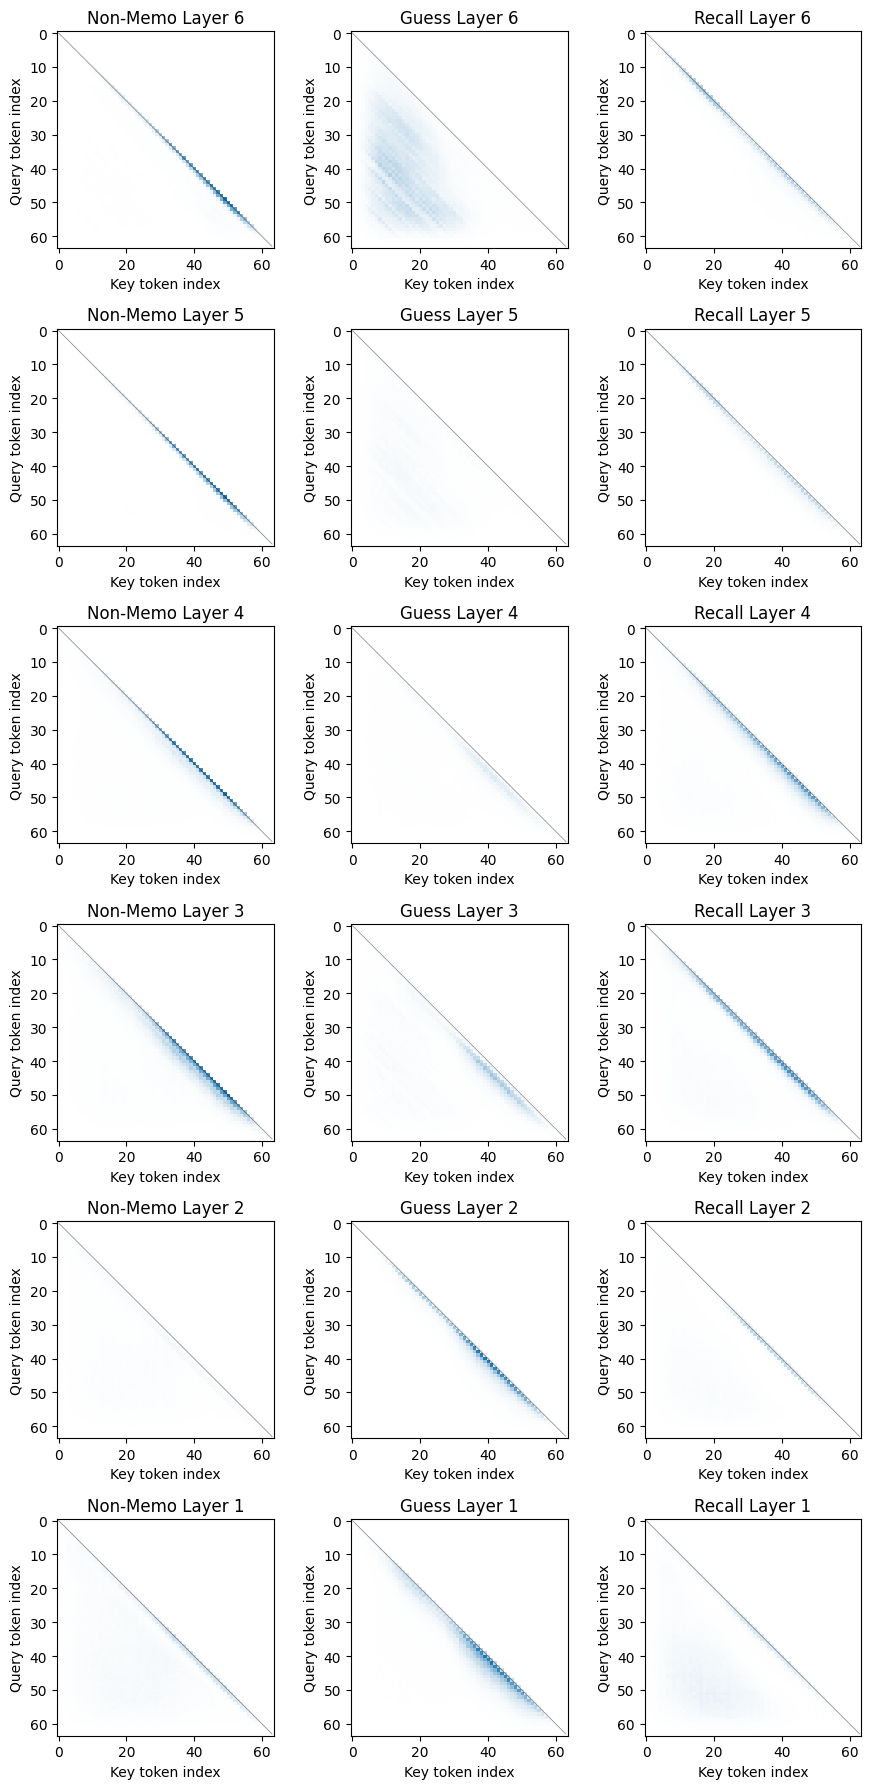

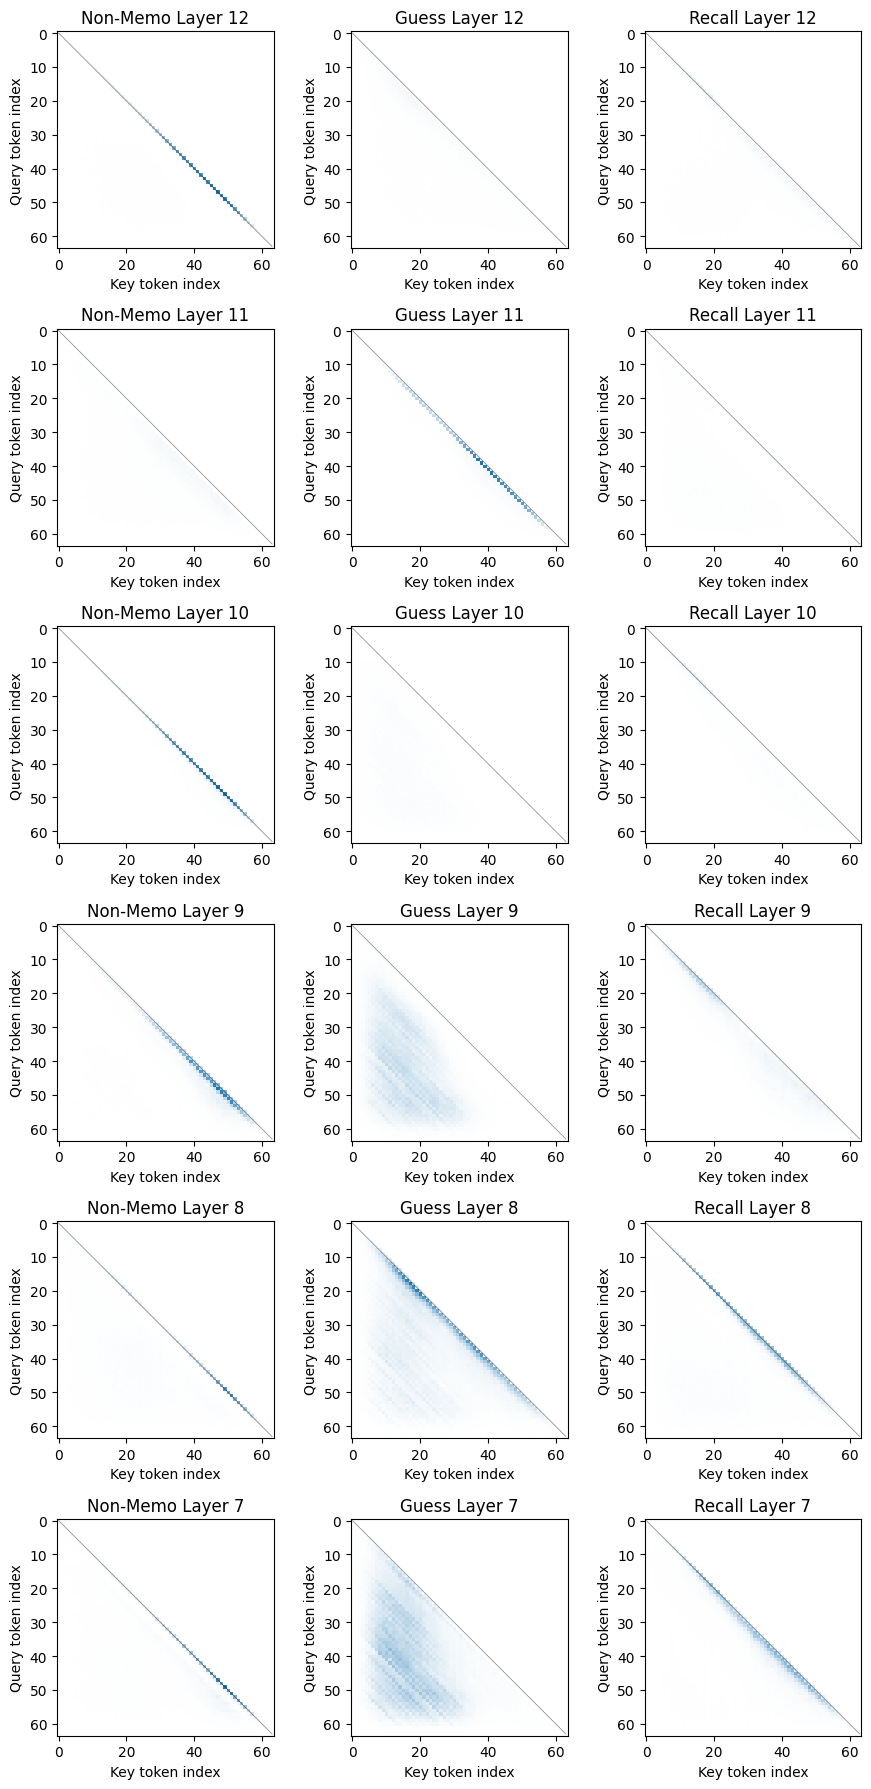

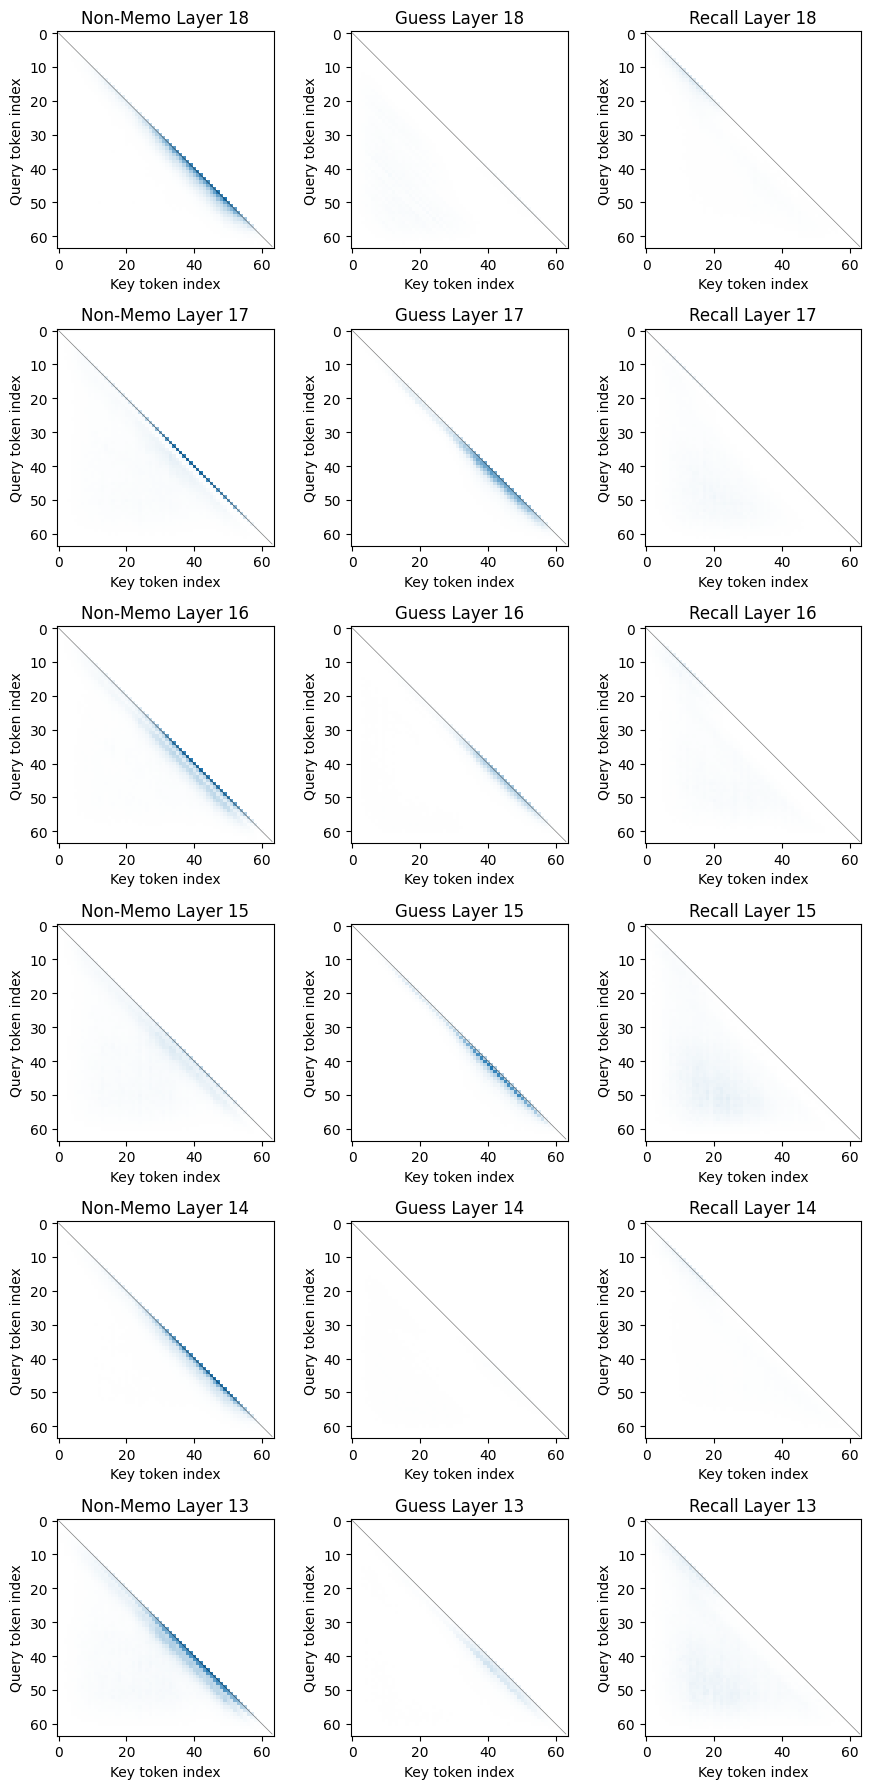

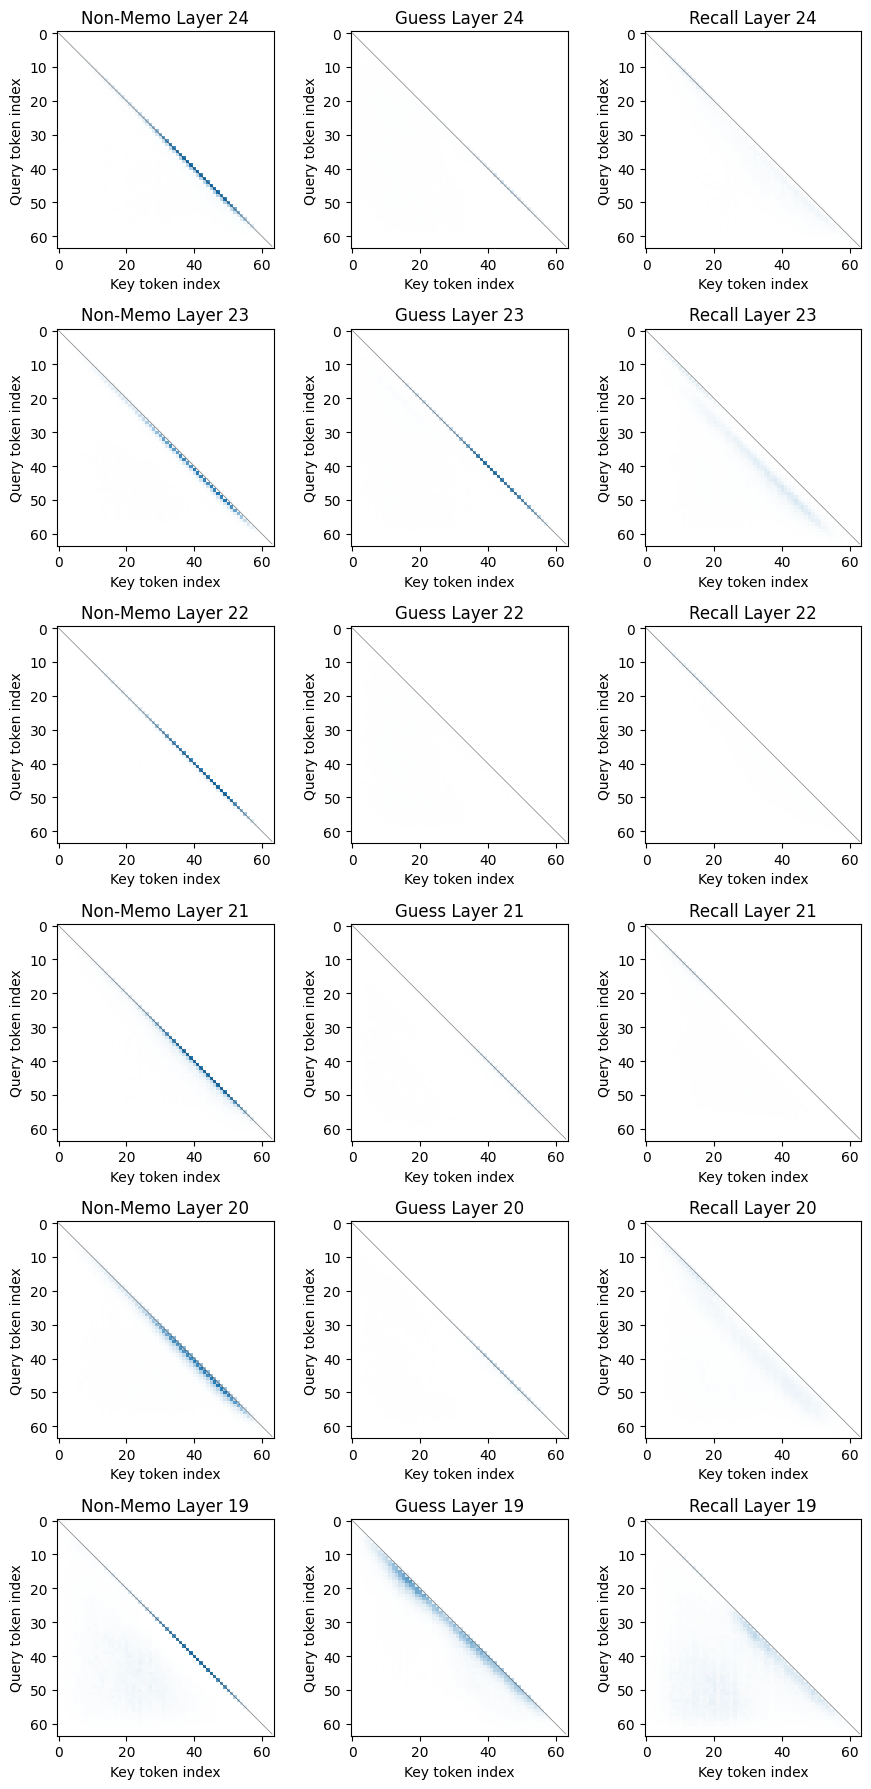

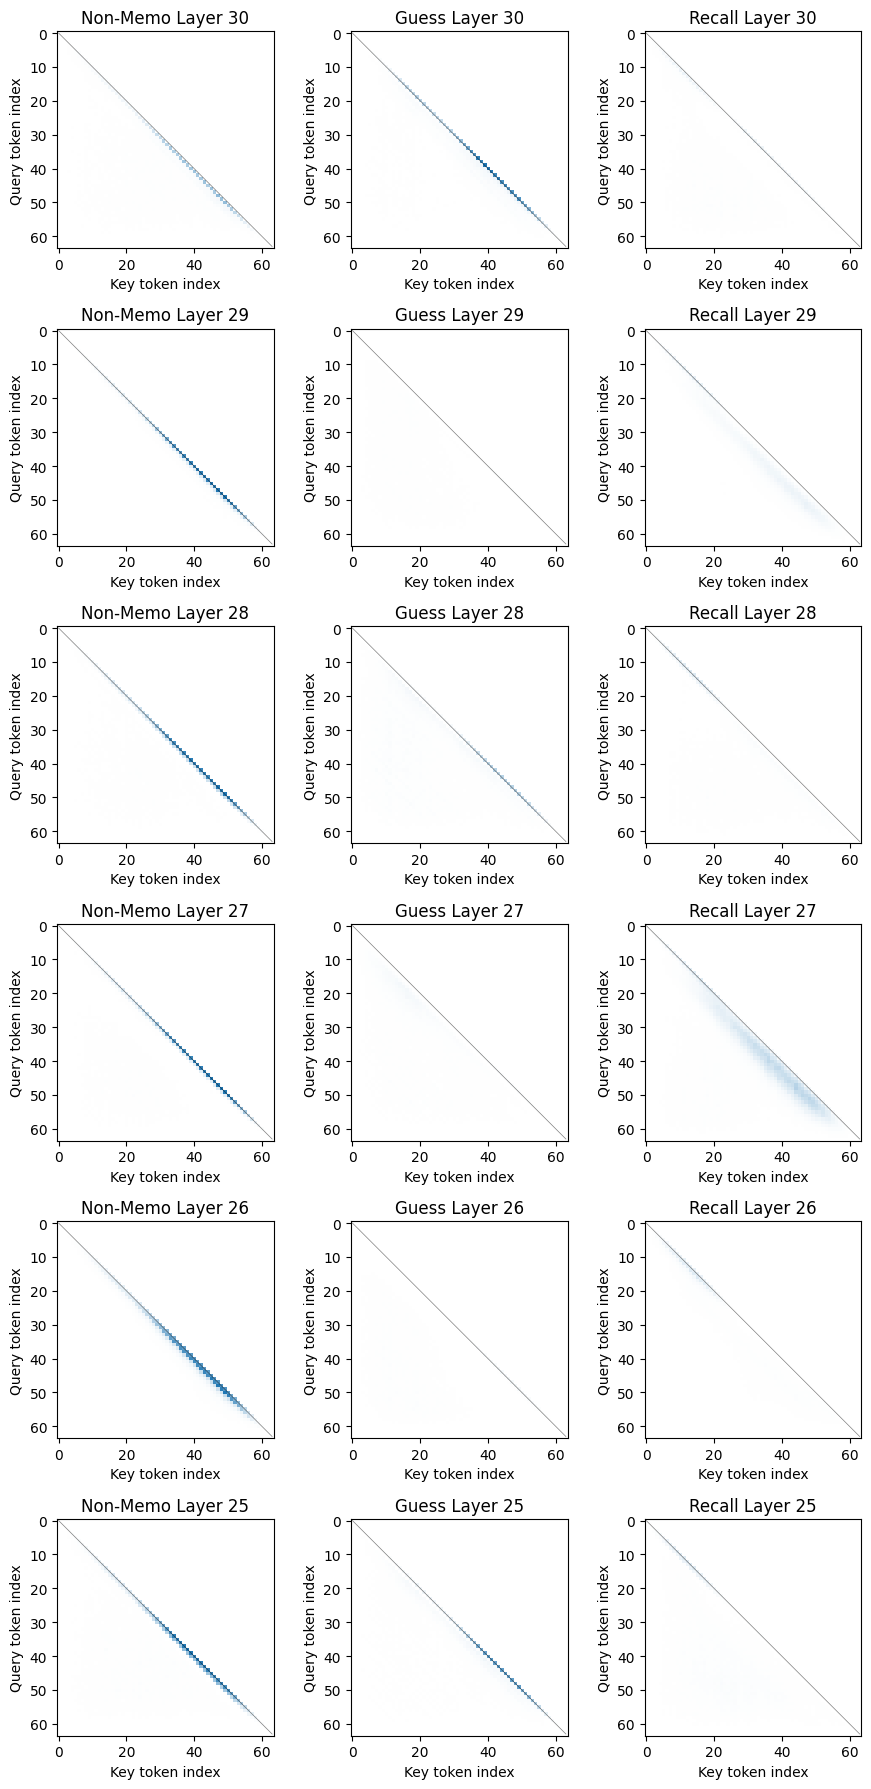

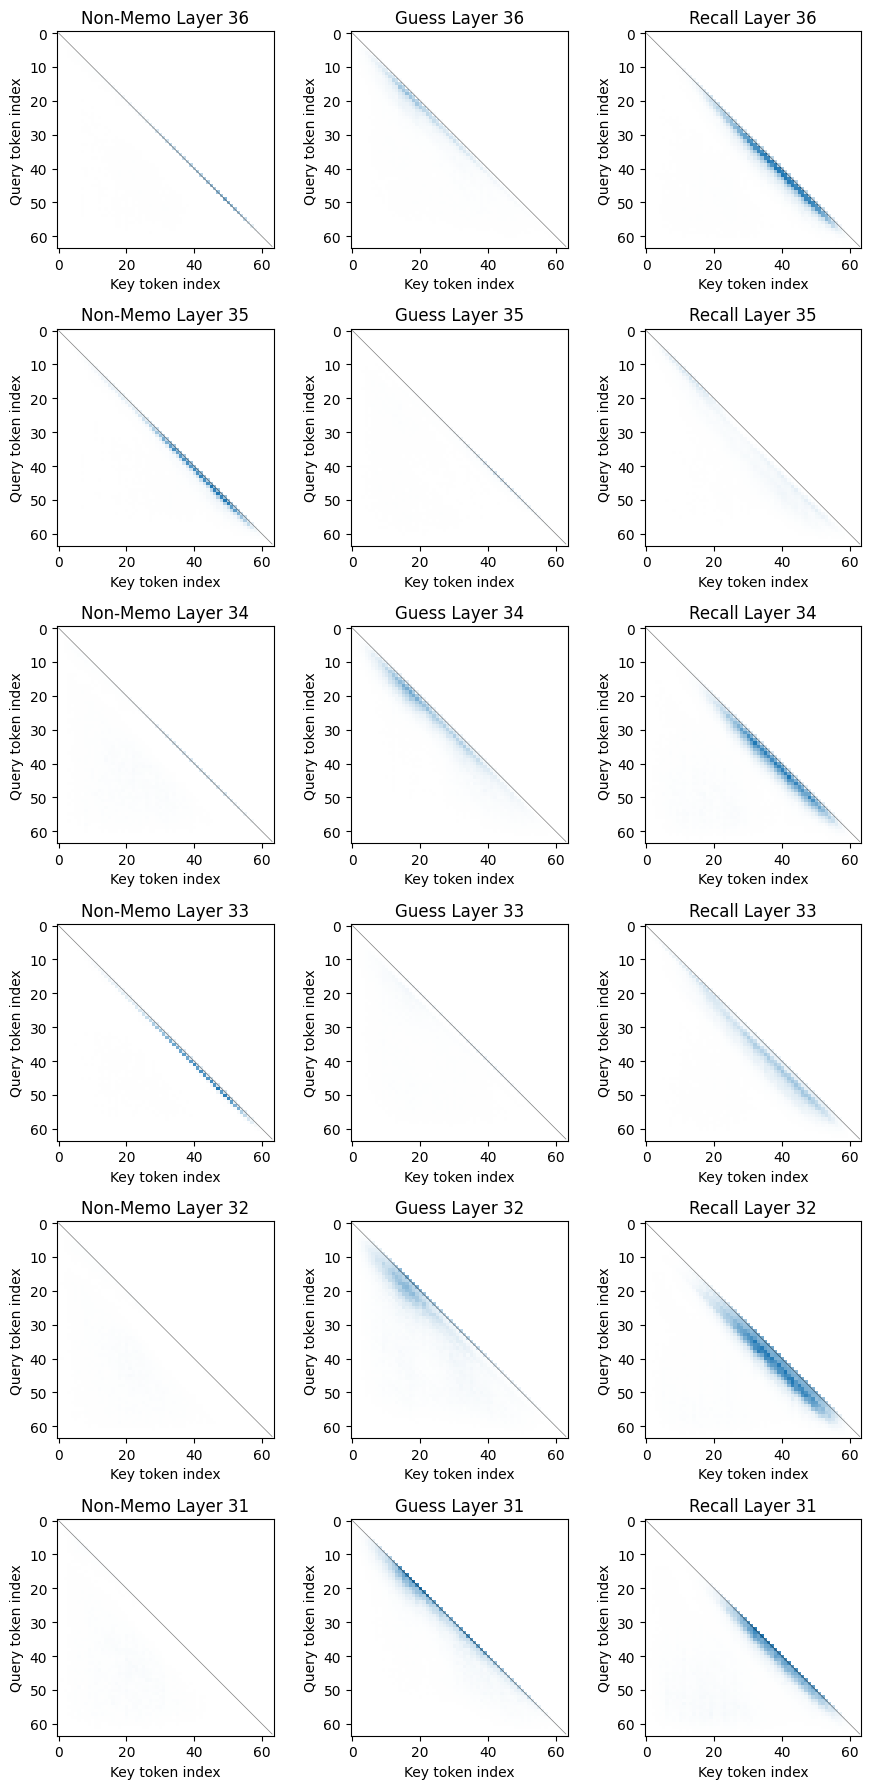

In [25]:
for LOW in range(0, 31, 6):
    HIGH = LOW + 6
    fig = plot_multisentence_multilayer(
        to_plot,
        head_pooling="max",
        gamma=1/5,
        add_diag=True,
        titles=TITLES,
        show_axlabels=True,
        layers_offset_in_title=1,
        layers=list(range(LOW,HIGH))[::-1],
    )
    if SAVE_FIG:
        fig.savefig(paths.figures / f"05_delta_matrix_{LOW+1}_{HIGH}.pdf")

## Teaser

In [26]:
classes_teaser = [0, 1, 2]
layers_teaser = [17, 5, 35]
tmp_to_plot = to_plot[
    torch.Tensor(classes_teaser).int(),
    None,
    torch.Tensor(layers_teaser).int(),
    :,:,:
]
tmp_to_plot.size()

torch.Size([3, 1, 1, 64, 64])

/var/folders/sm/rc925df91t51vmr_0m6wpdj80000gn/T/ipykernel_42390/2437179981.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


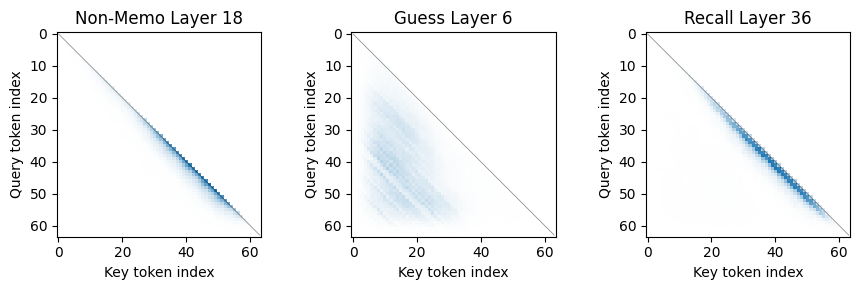

In [27]:
filtered_titles = [TITLES[k] for k in classes_teaser]
fig = plot_multisentence_multilayer(tmp_to_plot, head_pooling="max", gamma=1/5, add_diag=True, titles=filtered_titles, show_axlabels=True)
for idx, ax in enumerate(fig.axes):
    ax.set_title(
        ax.get_title()[:-1] + str(layers_teaser[idx] + 1)
    )
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(paths.figures / "05_decisiveness_patterns.pdf")
fig.show()

## Layer analysis

In [28]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [29]:
delta_matrix[0].shape

torch.Size([36, 1, 64, 64])

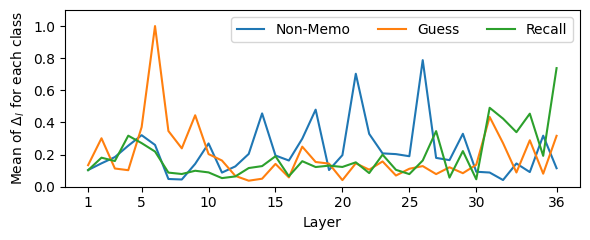

In [30]:
fig, ax = plt.subplots(figsize=(6, 2.5))

max_value = 0
for idx_class in range(num_classes):
    val = torch.sum(delta_matrix[idx_class], dim=(1,2,3))
    max_value = max(max_value, torch.amax(val).item())
for idx_class in range(num_classes):
    val = torch.sum(delta_matrix[idx_class], dim=(1,2,3))
    val /= max_value
    ax.plot(range(1, 37), val, color=COLORS[idx_class], label=TITLES[idx_class])

ax.set_xlabel("Layer")
ax.set_ylabel(r'Mean of $\Delta_l$ for each class')
ax.set_ylim(0, 1.1)
ax.legend(ncols=3, loc="upper right")
fig.tight_layout()
ax.set_xticks([1,5,10,15,20,25,30,36])
if SAVE_FIG:
    fig.savefig(paths.figures / "05_layer_analysis.pdf")
plt.show()